In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
eng = create_engine('sqlite:///Resources/hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(eng, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
clsMes = Base.classes.measurement
clsSta = Base.classes.station

In [9]:
# Create inspector to fetch field names
ins=inspect(eng)

In [10]:
# get "measurement" table's field names
lstCol=ins.get_columns('measurement')
for col in lstCol:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# get "station" table's field names
lstCol=ins.get_columns('station')
for col in lstCol:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create our session (link) from Python to the DB
ses = Session(eng)

In [13]:
# Create a connection to the DB
conn=eng.connect()

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
eng.execute('select min(date), max(date) from measurement').fetchall()

[('2010-01-01', '2017-08-23')]

In [15]:
# Perform a query to retrieve the data and precipitation scores
# "LTM" = "Last Twelve Months"
strSQL_LTM = 'SELECT m.id, m.date, m.prcp, m.tobs, s.station, s.name, s.latitude, s.longitude, s.elevation ' + \
             'FROM measurement m ' + \
             'INNER JOIN station s on m.station = s.station ' + \
             'WHERE date >= "2016-08-23"'

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dfLTM = pd.read_sql(strSQL_LTM, conn)

In [17]:
# Sort the dataframe by date
dfLTM = dfLTM.sort_values('date')

In [18]:
# Drop precipitation column NaNs
dfLTM = dfLTM.dropna(subset=['prcp'], thresh=1)

In [19]:
# Summarize the LTM data for a cleaner graph
# "LTMSumm" = "Last Twelve Months Summary"
dfLTMSumm = dfLTM.filter(items=['date', 'prcp'])
grpLTMSumm = dfLTMSumm.groupby('date')
dfLTMSumm = grpLTMSumm.mean()
dfLTMSumm = dfLTMSumm.reset_index()
dfLTMSumm.head()

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


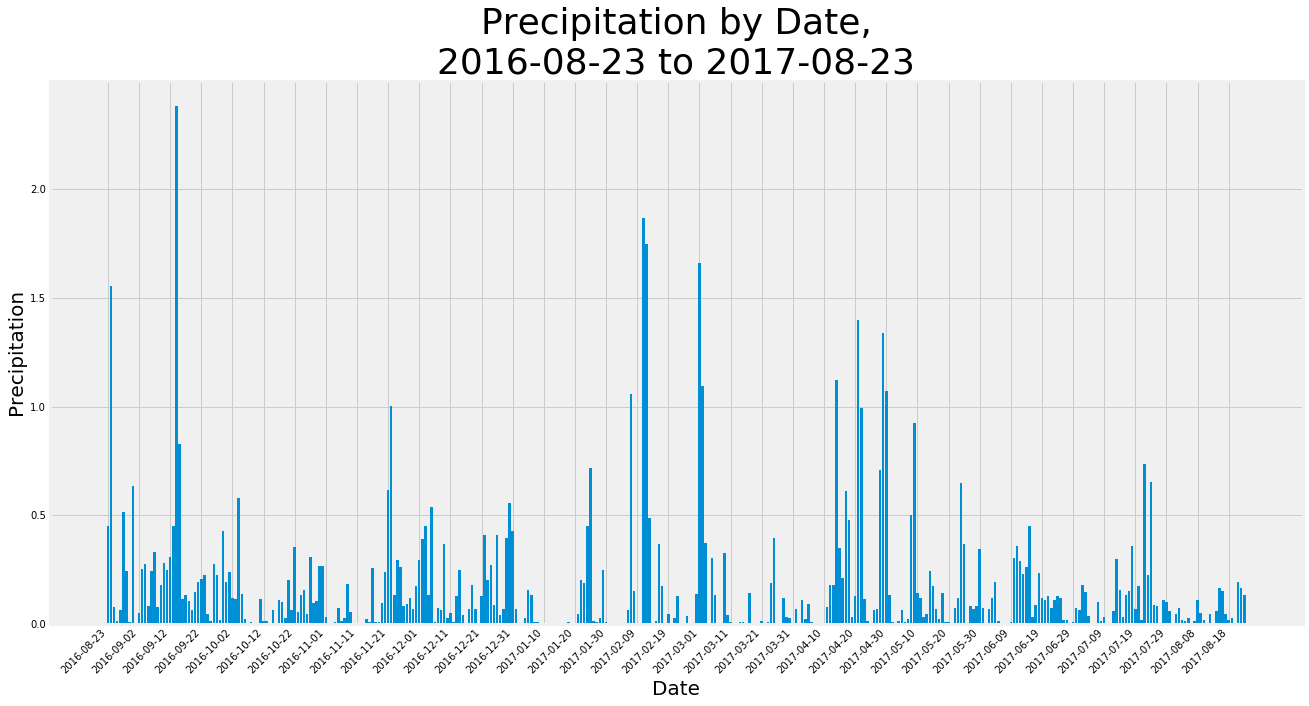

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(dfLTMSumm['date'], dfLTMSumm['prcp'])
plt.title('Precipitation by Date,\n2016-08-23 to 2017-08-23', fontsize=36)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Precipitation', fontsize=20)
fig=plt.gcf()
fig.set_size_inches(20, 10)
plt.xticks(rotation=45, ha='right')
plt.xticks(dfLTMSumm['date'][::10], dfLTMSumm['date'][::10])
plt.savefig('Precip by Date.png')
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
dfLTMSumm['prcp'].describe()

count    366.000000
mean       0.170757
std        0.295683
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: prcp, dtype: float64

In [22]:
# Design a query to show how many stations are available in this dataset?
strSQL_Stn = 'SELECT station, count(id) AS stncount ' + \
             'FROM measurement m ' +\
             'GROUP BY station ' + \
             'ORDER BY stncount DESC'

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
lstStn=eng.execute(strSQL_Stn).fetchall()
lstStn

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# store the Most Active Station as a variable
# "MAS" = "Most Active Station"
strMAS = lstStn[0][0]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
strSQL_MAS = 'SELECT station, MIN(tobs), MAX(tobs), AVG(tobs) ' + \
             'FROM measurement ' + \
             'WHERE station = "' + strMAS + '" ' + \
             'GROUP BY station '
lstMAS = eng.execute(strSQL_MAS).fetchall()
lstMAS

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

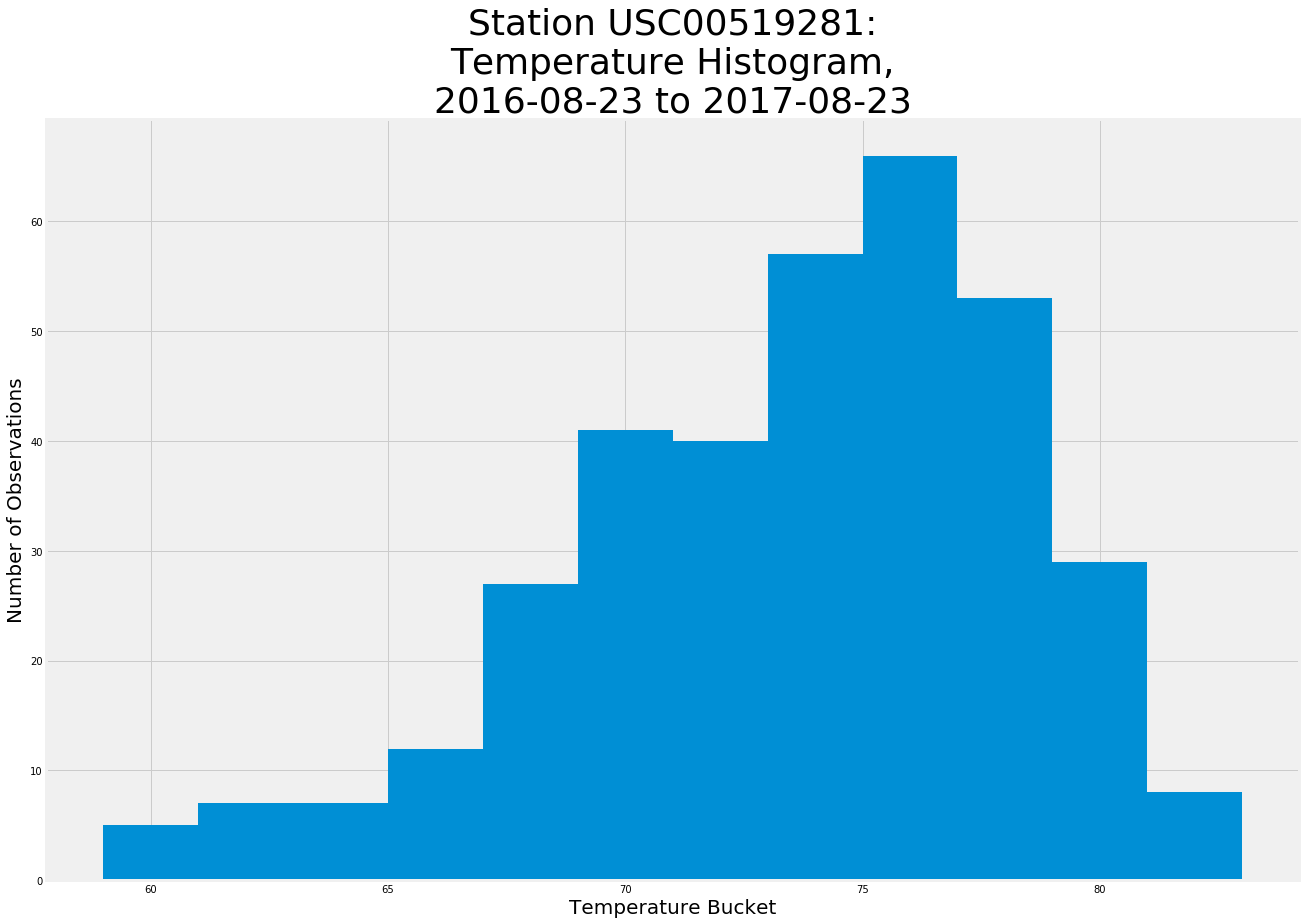

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# "LTMMAS" = "Last Twelve Months, Most Active Station"
dfLTMMAS = dfLTM[dfLTM['station'] == strMAS]
# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(dfLTMMAS['tobs'], 12)
plt.title(f'Station {strMAS}:\nTemperature Histogram,\n2016-08-23 to 2017-08-23', fontsize=36)
plt.xlabel('Temperature Bucket', fontsize=20)
plt.ylabel('Number of Observations', fontsize=20)
fig=plt.gcf()
fig.set_size_inches(20, 14)
plt.savefig('Temp Histogram.png')
plt.show()

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return ses.query(func.min(clsMes.tobs), func.avg(clsMes.tobs), func.max(clsMes.tobs)).\
        filter(clsMes.date >= start_date).filter(clsMes.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
lstTmp = calc_temps('2017-07-20', '2017-07-28')

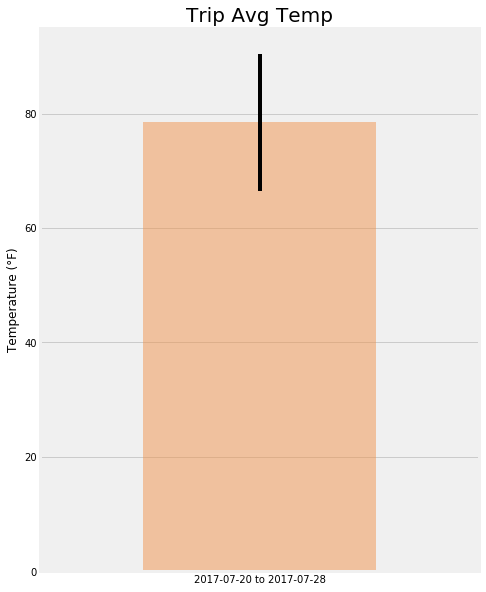

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar('2017-07-20 to 2017-07-28', lstTmp[0][1], yerr=lstTmp[0][2]-lstTmp[0][0], color='xkcd:faded orange', alpha=.5)
plt.title('Trip Avg Temp', fontsize=20)
plt.xlim(-0.75, 0.75)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.grid(axis='x')
fig=plt.gcf()
fig.set_size_inches(7, 10)
plt.savefig('Trip Avg Temp.png')
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
strSQL_Vac = 'SELECT s.station, s.name, s.latitude, s.longitude, s.elevation, SUM(m.prcp) AS TotPrcp ' + \
             'FROM measurement m ' + \
             'INNER JOIN station s on m.station = s.station ' + \
             'WHERE date >= "2017-07-20" ' + \
             'AND date <= "2017-07-28" ' + \
             'GROUP BY s.station, s.name, s.latitude, s.longitude, s.elevation ' + \
             'ORDER BY TotPrcp DESC'
dfVac = pd.read_sql(strSQL_Vac, conn)
dfVac

,station,name,latitude,longitude,elevation,TotPrcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.44
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.66
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.43
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.05
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.38
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.11
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(clsMes.tobs), func.avg(clsMes.tobs), func.max(clsMes.tobs)]
    return ses.query(*sel).filter(func.strftime("%m-%d", clsMes.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
dtStart = '2019-07-20'
dtEnd = '2019-07-28'

In [33]:
# Use the start and end date to create a range of dates
lstDt = pd.date_range(dtStart, periods=9).tolist()
lstDt

[Timestamp('2019-07-20 00:00:00', freq='D'),
 Timestamp('2019-07-21 00:00:00', freq='D'),
 Timestamp('2019-07-22 00:00:00', freq='D'),
 Timestamp('2019-07-23 00:00:00', freq='D'),
 Timestamp('2019-07-24 00:00:00', freq='D'),
 Timestamp('2019-07-25 00:00:00', freq='D'),
 Timestamp('2019-07-26 00:00:00', freq='D'),
 Timestamp('2019-07-27 00:00:00', freq='D'),
 Timestamp('2019-07-28 00:00:00', freq='D')]

In [34]:
# Stip off the year and save a list of %m-%d strings
lstMMDD = [dt.strftime("%m-%d") for dt in lstDt]
lstMMDD

['07-20',
 '07-21',
 '07-22',
 '07-23',
 '07-24',
 '07-25',
 '07-26',
 '07-27',
 '07-28']

In [35]:
# Loop through the list of %m-%d strings and calculate the normals for each date
lstNorm = [daily_normals(MMDD) for MMDD in lstMMDD]
lstNorm

[[(69.0, 75.46296296296296, 82.0)],
 [(69.0, 76.9245283018868, 83.0)],
 [(69.0, 75.78846153846153, 81.0)],
 [(70.0, 76.20370370370371, 84.0)],
 [(69.0, 76.55555555555556, 81.0)],
 [(67.0, 76.89090909090909, 84.0)],
 [(71.0, 76.4423076923077, 86.0)],
 [(68.0, 76.58181818181818, 83.0)],
 [(69.0, 76.46428571428571, 82.0)]]

In [36]:
# pull lows out of lstNorm
lstLow = [row[0][0] for row in lstNorm]
lstLow

[69.0, 69.0, 69.0, 70.0, 69.0, 67.0, 71.0, 68.0, 69.0]

In [37]:
# pull avgs out of lstNorm
lstAvg = [row[0][1] for row in lstNorm]
lstAvg

[75.46296296296296,
 76.9245283018868,
 75.78846153846153,
 76.20370370370371,
 76.55555555555556,
 76.89090909090909,
 76.4423076923077,
 76.58181818181818,
 76.46428571428571]

In [38]:
# pull highs out of lstNorm
lstHigh = [row[0][2] for row in lstNorm]
lstHigh

[82.0, 83.0, 81.0, 84.0, 81.0, 84.0, 86.0, 83.0, 82.0]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfNorm = pd.DataFrame(columns=['date', 'low', 'avg', 'high'])
dfNorm['date'] = lstMMDD
dfNorm = dfNorm.set_index('date')
dfNorm['low'] = lstLow
dfNorm['avg'] = lstAvg
dfNorm['high'] = lstHigh
dfNorm

,low,avg,high
date,,,
07-20,69.0,75.462963,82.0
07-21,69.0,76.924528,83.0
07-22,69.0,75.788462,81.0
07-23,70.0,76.203704,84.0
07-24,69.0,76.555556,81.0
07-25,67.0,76.890909,84.0
07-26,71.0,76.442308,86.0
07-27,68.0,76.581818,83.0
07-28,69.0,76.464286,82.0


<Figure size 432x288 with 0 Axes>

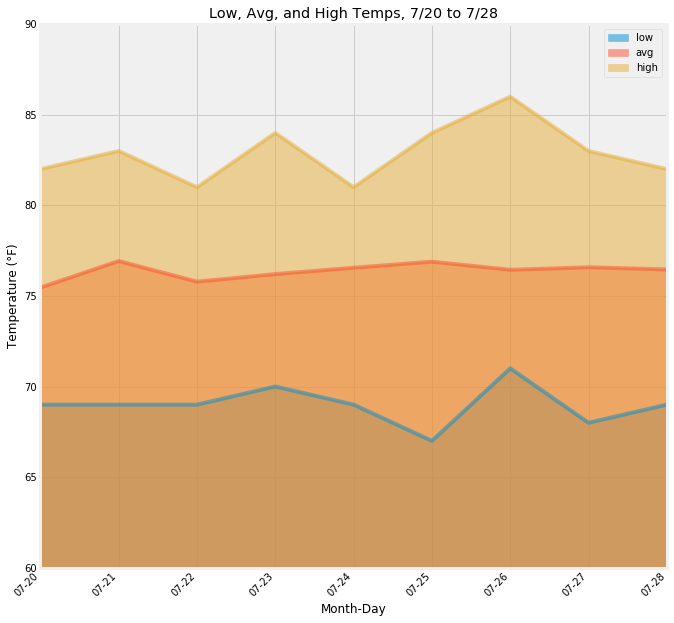

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure()
dfNorm.plot.area(stacked=False)
plt.xlabel('Month-Day')
plt.ylabel('Temperature (°F)')
plt.ylim(60, 90)
plt.title('Low, Avg, and High Temps, 7/20 to 7/28')
plt.xticks(rotation=45, ha='right')
fig=plt.gcf()
fig.set_size_inches(10, 10)
plt.savefig('Low, Avg, and High Temps')
plt.show()